[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neurogym/ngym_usage/blob/master/supervised/auto_notebooks/supervised/PerceptualDecisionMaking-v0.ipynb)

### Install packages if on Colab

In [15]:
# Uncomment following lines to install
! pip install gym   # Install gym
! git clone https://github.com/gyyang/neurogym.git  # Install neurogym
%cd neurogym/
! pip install -e .


fatal: destination path 'neurogym' already exists and is not an empty directory.
/content/neurogym/neurogym
Obtaining file:///content/neurogym/neurogym
ERROR: file:///content/neurogym/neurogym does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


### Import packages

In [16]:
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import gym
import neurogym as ngym

device = 'cuda' if torch.cuda.is_available() else 'cpu'


envid = 'PerceptualDecisionMaking-v0'

In [17]:
def get_modelpath(envid):
    # Make a local file directories
    path = Path('.') / 'files'
    os.makedirs(path, exist_ok=True)
    path = path / envid
    os.makedirs(path, exist_ok=True)
    return path


### Define network

In [18]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, hidden = self.lstm(x)
        x = self.linear(out)
        return x, out


### Train network

In [19]:
"""Supervised training networks.

Save network in a path determined by environment ID.

Args:
    envid: str, environment ID.
"""
modelpath = get_modelpath(envid)
config = {
    'dt': 100,
    'hidden_size': 64,
    'lr': 1e-2,
    'batch_size': 16,
    'seq_len': 100,
    'envid': envid,
}

env_kwargs = {'dt': config['dt']}
config['env_kwargs'] = env_kwargs

# Save config
with open(modelpath / 'config.json', 'w') as f:
    json.dump(config, f)

# Make supervised dataset
dataset = ngym.Dataset(
    envid, env_kwargs=env_kwargs, batch_size=config['batch_size'],
    seq_len=config['seq_len'])
env = dataset.env
act_size = env.action_space.n
# Train network
net = Net(input_size=env.observation_space.shape[0],
          hidden_size=config['hidden_size'],
          output_size=act_size)
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=config['lr'])

print('Training task ', envid)

running_loss = 0.0
for i in range(2000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, _ = net(inputs)

    loss = criterion(outputs.view(-1, act_size), labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 200 == 199:
        print('{:d} loss: {:0.5f}'.format(i + 1, running_loss / 200))
        running_loss = 0.0
        torch.save(net.state_dict(), modelpath / 'net.pth')

print('Finished Training')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Training task  PerceptualDecisionMaking-v0
200 loss: 0.11630
400 loss: 0.02893
600 loss: 0.01542
800 loss: 0.01236
1000 loss: 0.01152
1200 loss: 0.01133
1400 loss: 0.01078
1600 loss: 0.01098
1800 loss: 0.01028
2000 loss: 0.01026
Finished Training


In [20]:
def infer_test_timing(env):
    """Infer timing of environment for testing."""
    timing = {}
    for period in env.timing.keys():
        period_times = [env.sample_time(period) for _ in range(100)]
        timing[period] = np.median(period_times)
    return timing


### Run network after training for analysis

In [21]:
"""Run trained networks for analysis.

Args:
    envid: str, Environment ID

Returns:
    activity: a list of activity matrices, each matrix has shape (
    N_time, N_neuron)
    info: pandas dataframe, each row is information of a trial
    config: dict of network, training configurations
"""
modelpath = get_modelpath(envid)
with open(modelpath / 'config.json') as f:
    config = json.load(f)

env_kwargs = config['env_kwargs']

# Run network to get activity and info
# Environment
env = gym.make(envid, **env_kwargs)
env.timing = infer_test_timing(env)
env.reset(no_step=True)

# Instantiate the network and print information
with torch.no_grad():
    net = Net(input_size=env.observation_space.shape[0],
              hidden_size=config['hidden_size'],
              output_size=env.action_space.n)
    net = net.to(device)
    net.load_state_dict(torch.load(modelpath / 'net.pth'))

    perf = 0
    num_trial = 100

    activity = list()
    info = pd.DataFrame()

    for i in range(num_trial):
        env.new_trial()
        ob, gt = env.ob, env.gt
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        action_pred, hidden = net(inputs)

        # Compute performance
        action_pred = action_pred.detach().numpy()
        choice = np.argmax(action_pred[-1, 0, :])
        correct = choice == gt[-1]

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice})
        info = info.append(trial_info, ignore_index=True)

        # Log stimulus period activity
        activity.append(np.array(hidden)[:, 0, :])

    print('Average performance', np.mean(info['correct']))

activity = np.array(activity)


<ipython-input-21-76a8e19bfe7e>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(trial_info, ignore_index=True)
<ipython-input-21-76a8e19bfe7e>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(trial_info, ignore_index=True)
<ipython-input-21-76a8e19bfe7e>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(trial_info, ignore_index=True)
<ipython-input-21-76a8e19bfe7e>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(trial_info, ignore_index=True)
<ipython-input-21-76a8e19bfe7e>:52: FutureWarning: The frame.append method is deprecated and will be removed from pa

Average performance 0.87


<ipython-input-21-76a8e19bfe7e>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(trial_info, ignore_index=True)
<ipython-input-21-76a8e19bfe7e>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(trial_info, ignore_index=True)


### General analysis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


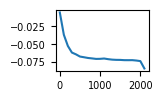

In [22]:
def analysis_average_activity(activity, info, config):
    # Load and preprocess results
    plt.figure(figsize=(1.2, 0.8))
    t_plot = np.arange(activity.shape[1]) * config['dt']
    plt.plot(t_plot, activity.mean(axis=0).mean(axis=-1))

analysis_average_activity(activity, info, config)

In [23]:
def get_conditions(info):
    """Get a list of task conditions to plot."""
    conditions = info.columns
    # This condition's unique value should be less than 5
    new_conditions = list()
    for c in conditions:
        try:
            n_cond = len(pd.unique(info[c]))
            if 1 < n_cond < 5:
                new_conditions.append(c)
        except TypeError:
            pass

    return new_conditions


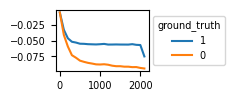

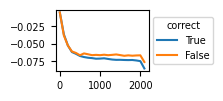

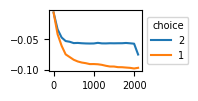

In [24]:
def analysis_activity_by_condition(activity, info, config):
    conditions = get_conditions(info)
    for condition in conditions:
        values = pd.unique(info[condition])
        plt.figure(figsize=(1.2, 0.8))
        t_plot = np.arange(activity.shape[1]) * config['dt']
        for value in values:
            a = activity[info[condition] == value]
            plt.plot(t_plot, a.mean(axis=0).mean(axis=-1), label=str(value))
        plt.legend(title=condition, loc='center left', bbox_to_anchor=(1.0, 0.5))

analysis_activity_by_condition(activity, info, config)

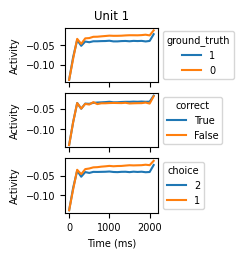

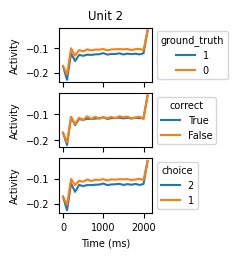

In [25]:
def analysis_example_units_by_condition(activity, info, config):
    conditions = get_conditions(info)
    if len(conditions) < 1:
        return

    example_ids = np.array([0, 1])
    for example_id in example_ids:
        example_activity = activity[:, :, example_id]
        fig, axes = plt.subplots(
                len(conditions), 1,  figsize=(1.2, 0.8 * len(conditions)),
                sharex=True)
        for i, condition in enumerate(conditions):
            ax = axes[i]
            values = pd.unique(info[condition])
            t_plot = np.arange(activity.shape[1]) * config['dt']
            for value in values:
                a = example_activity[info[condition] == value]
                ax.plot(t_plot, a.mean(axis=0), label=str(value))
            ax.legend(title=condition, loc='center left', bbox_to_anchor=(1.0, 0.5))
            ax.set_ylabel('Activity')
            if i == len(conditions) - 1:
                ax.set_xlabel('Time (ms)')
            if i == 0:
                ax.set_title('Unit {:d}'.format(example_id + 1))

analysis_example_units_by_condition(activity, info, config)

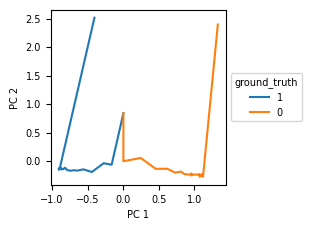

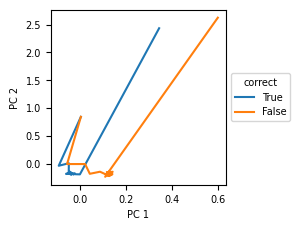

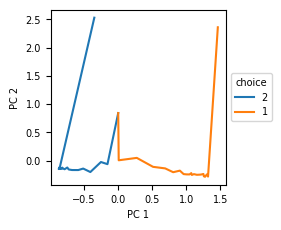

In [26]:
def analysis_pca_by_condition(activity, info, config):
    # Reshape activity to (N_trial x N_time, N_neuron)
    activity_reshape = np.reshape(activity, (-1, activity.shape[-1]))
    pca = PCA(n_components=2)
    pca.fit(activity_reshape)

    conditions = get_conditions(info)
    for condition in conditions:
        values = pd.unique(info[condition])
        fig = plt.figure(figsize=(2.5, 2.5))
        ax = fig.add_axes([0.2, 0.2, 0.7, 0.7])
        for value in values:
            # Get relevant trials, and average across them
            a = activity[info[condition] == value].mean(axis=0)
            a = pca.transform(a)  # (N_time, N_PC)
            plt.plot(a[:, 0], a[:, 1], label=str(value))
        plt.legend(title=condition, loc='center left', bbox_to_anchor=(1.0, 0.5))

        plt.xlabel('PC 1')
        plt.ylabel('PC 2')

analysis_pca_by_condition(activity, info, config)